In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import set_to_nan_based_on_likelihood, plot_ebc,filter_and_interpolate

In [3]:
file = r'\\rhea\E\20240608\WT0008LN\FM\20240608_WT0008LN_M_FM_DMS1_angie_ephys_topDLCephys.h5'
dlc_df = pd.read_hdf(file, 'dlc_df')
phy_df = pd.read_hdf(file, 'phy_df')

fps = 59.99
likelihood_threshold = 0.95
model_dt = 1/fps # Frame duration in seconds
bin_width = 20 #bin width angles
speed_threshold=0.25
ebc_angle_bin_size = 3
ebc_dist_bin_size = 40

columns_of_interest = ['center_haunch','left_drive','right_drive', 'time']

# Adding timestamps to dlc file and only considering columns of interest
dlc_df['time'] = np.arange(len(dlc_df))/fps

#filter and interpolate
model_data_df,model_t = filter_and_interpolate(dlc_df,columns_of_interest,likelihood_threshold,model_dt,fps)

model_data_df = model_data_df[model_data_df['speed']>speed_threshold]

#model_data_df = model_data_df.dropna()


In [4]:
model_data_df

,left_drive x,left_drive y,right_drive x,right_drive y,center_haunch x,center_haunch y,speed
0,892.184143,209.159698,897.464508,233.962379,823.480255,259.446289,5.350794
1,894.016571,213.093163,898.283722,237.768501,823.944366,259.446289,5.350794
2,895.753815,215.835129,899.219208,240.119286,824.371948,258.661041,6.897307
3,898.904816,217.074173,901.042480,241.027908,824.679779,257.049667,9.299791
4,902.066986,217.600723,904.214752,241.027908,825.989502,255.743217,11.562486
...,...,...,...,...,...,...,...
217766,1124.081055,880.026764,1120.761353,856.203796,1172.645386,874.742218,4.086175
217767,1123.807983,880.070404,1120.761353,855.828003,1172.645386,874.683899,2.740448
217768,1123.207886,879.985107,1120.500366,855.828003,1172.640320,874.537964,1.252743
217769,1122.874329,879.960205,1119.883545,855.828003,1172.460693,874.039581,1.252743


In [5]:
i = 30
spike_times = phy_df.iloc[i]['spikeT']

In [6]:
model_data_df

,left_drive x,left_drive y,right_drive x,right_drive y,center_haunch x,center_haunch y,speed
0,892.184143,209.159698,897.464508,233.962379,823.480255,259.446289,5.350794
1,894.016571,213.093163,898.283722,237.768501,823.944366,259.446289,5.350794
2,895.753815,215.835129,899.219208,240.119286,824.371948,258.661041,6.897307
3,898.904816,217.074173,901.042480,241.027908,824.679779,257.049667,9.299791
4,902.066986,217.600723,904.214752,241.027908,825.989502,255.743217,11.562486
...,...,...,...,...,...,...,...
217766,1124.081055,880.026764,1120.761353,856.203796,1172.645386,874.742218,4.086175
217767,1123.807983,880.070404,1120.761353,855.828003,1172.645386,874.683899,2.740448
217768,1123.207886,879.985107,1120.500366,855.828003,1172.640320,874.537964,1.252743
217769,1122.874329,879.960205,1119.883545,855.828003,1172.460693,874.039581,1.252743


In [7]:
hds = []
y = list(model_data_df['left_drive y']-model_data_df['right_drive y'])
x = list(model_data_df['left_drive x']-model_data_df['right_drive x'])
for i in range(len(x)):
    hds.append(math.atan2(y[i],x[i]) + np.deg2rad(90))

In [8]:
model_data_df['head_direction'] = hds

In [9]:
model_data_df = model_data_df[model_data_df['center_haunch x']<1200]

In [10]:
spike_times = spike_times[spike_times <= max(model_t)]

# Binning spikes
sp_count_ind = np.digitize(spike_times, bins=model_t)

# -1 because np.digitize is 1-indexed
sp_count_ind = [i - 1 for i in sp_count_ind]

sp_count_ind = [i for i in sp_count_ind if i in model_data_df.index]



# Get corresponding mouse positions for spike times
mouse_x = list(model_data_df[columns_of_interest[0] + ' x'][sp_count_ind])
mouse_y = list(model_data_df[columns_of_interest[0] + ' y'][sp_count_ind])
head_direction = np.rad2deg(list(model_data_df['head_direction'][sp_count_ind]))


In [20]:
trajectory_df = dlc_df[['center_haunch x', 'center_haunch y']]

In [24]:
trajectory_df = trajectory_df[trajectory_df['center_haunch x']>400]
trajectory_df = trajectory_df[trajectory_df['center_haunch x']<1200]
trajectory_df = trajectory_df[trajectory_df['center_haunch y']>100]
trajectory_df = trajectory_df[trajectory_df['center_haunch y']<900]

In [25]:
ch_points_x = list(trajectory_df['center_haunch x'])
ch_points_y = list(trajectory_df['center_haunch y'])

C:\Users\plab\AppData\Local\Temp\ipykernel_23112\3146302882.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "og" (-> color='g'). The keyword argument will take precedence.
  plt.plot(ch_points_x, ch_points_y, "og", markersize=1,color='grey')


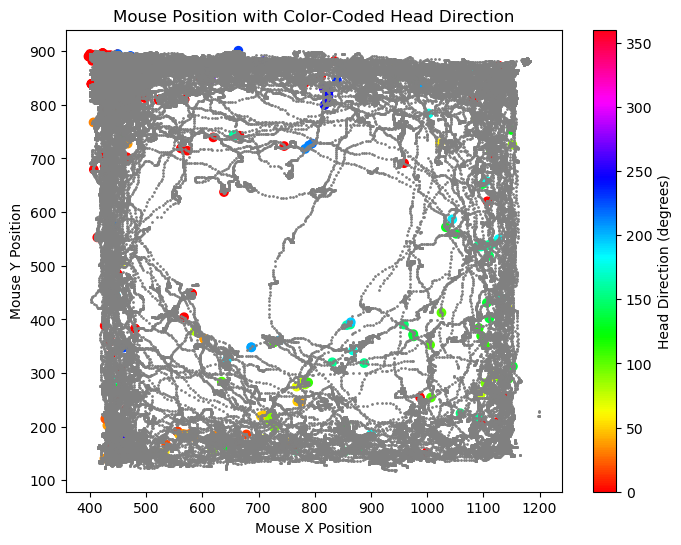

In [37]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.plot(ch_points_x, ch_points_y, "og", markersize=1,color='grey')
scatter = plt.scatter(mouse_x, mouse_y, c=head_direction, cmap='hsv',vmin=0, vmax=360)

# Add a color bar to show the head direction
cbar = plt.colorbar(scatter)
cbar.set_label('Head Direction (degrees)')

# Label the axes
plt.xlabel('Mouse X Position')
plt.ylabel('Mouse Y Position')

# Add a title
plt.title('Mouse Position with Color-Coded Head Direction')

# Display the plot
plt.show()

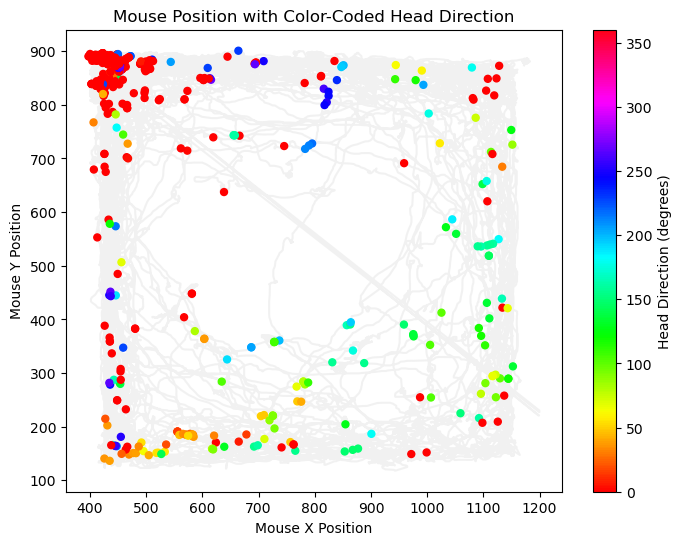

In [49]:
import matplotlib.pyplot as plt

# Plot the ch_points_x and ch_points_y in light grey with a smaller marker size
plt.figure(figsize=(8, 6))
plt.plot(ch_points_x, ch_points_y, "-", markersize=0.5, color='lightgrey', alpha=0.3)

# Then, overlay the scatter plot with a higher z-order to ensure it appears on top
scatter = plt.scatter(mouse_x, mouse_y, c=head_direction, cmap='hsv', vmin=0, vmax=360, s=25, alpha=1.0, zorder=10)

# Add a color bar to show the head direction
cbar = plt.colorbar(scatter)
cbar.set_label('Head Direction (degrees)')

# Label the axes
plt.xlabel('Mouse X Position')
plt.ylabel('Mouse Y Position')

# Add a title
plt.title('Mouse Position with Color-Coded Head Direction')

# Display the plot
plt.show()


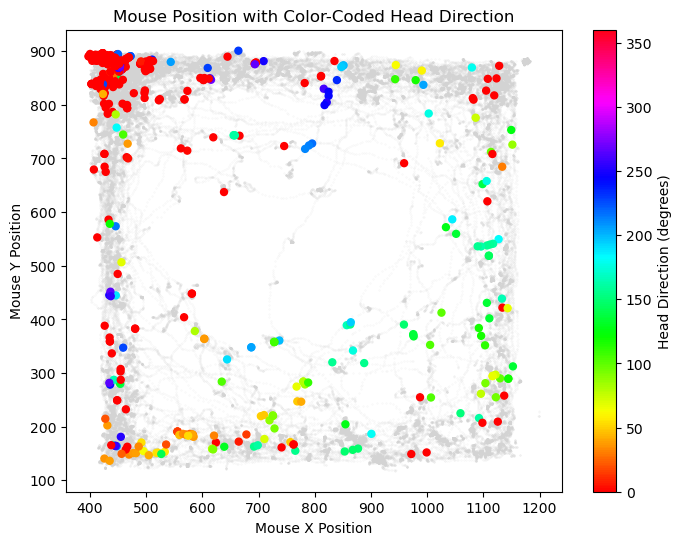

In [55]:
import matplotlib.pyplot as plt

# Plot the ch_points_x and ch_points_y in light grey with a smaller marker size
plt.figure(figsize=(8, 6))
plt.plot(ch_points_x, ch_points_y, ".", markersize=0.5, color='lightgrey', alpha=0.3,rasterized=True)

# Then, overlay the scatter plot with a higher z-order to ensure it appears on top
scatter = plt.scatter(mouse_x, mouse_y, c=head_direction, cmap='hsv', vmin=0, vmax=360, s=25, alpha=1.0, zorder=10,rasterized=True)

# Add a color bar to show the head direction
cbar = plt.colorbar(scatter)
cbar.set_label('Head Direction (degrees)')

# Label the axes
plt.xlabel('Mouse X Position')
plt.ylabel('Mouse Y Position')

# Add a title
plt.title('Mouse Position with Color-Coded Head Direction')

# Display the plot
plt.show()


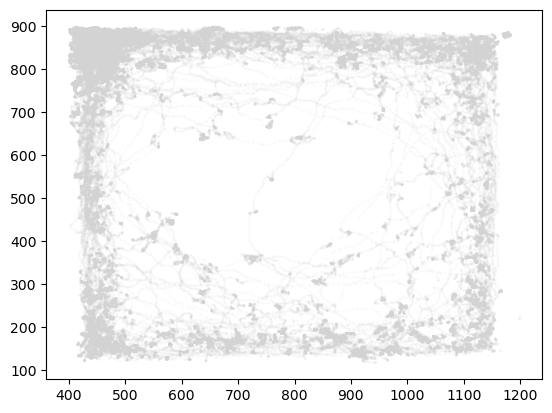

In [51]:
plt.plot(ch_points_x, ch_points_y, ".", markersize=0.5, color='lightgrey', alpha=0.3)